## Некорректные коммутации
В ТОЭ существует класс задач, где не выполняются законы коммутации (сохранение тока через индуктивность и напряжения на ёмкости). Это связано с идеализацией схем замещения (нулевое активное сопротивление) и особой конфигурацией схемы.

Такие коммутации называются некорректными и разрешение данного вопроса возможно несколькими путями:
* ввод небольших сопротивлений в схему замещения;
* использование обобщенных законов коммутации (постоянство суммарного потокосцепления схемы и суммарного заряда схемы). При этом допускается наличие бесконечно больших напряжений на индуктивностях и токов через конденсаторы, которые действуют в момент коммутации и приводят к скачкообразному изменению токов через индуктивность и напряжений на ёмкости.

Попробуем провести такой расчет с использованием библиотеки ModelingToolkit.jl

![Схема](Capture.png)

In [1]:
using ModelingToolkit, OrdinaryDiffEq, Plots
using ModelingToolkitStandardLibrary.Electrical
using ModelingToolkitStandardLibrary.Blocks: Constant

Начнем с корректной постановки задачи согласно картинке.
Определим исходные данные и составим "матрицу" соединений

In [2]:
R1 = 1.0
C1 = 1.0
E = 100.0
R2 = 0.5
C2 = 0.5

@variables t
@named resistor1 = Resistor(R = R1)
@named resistor2 = Resistor(R = R2)
@named capacitor1 = Capacitor(C = C1, v = E)
@named capacitor2 = Capacitor(C = C2, v = 40)
@named source = Voltage()
@named constant = Constant(k = E)
@named ground = Ground()

rc_eqs = [connect(constant.output, source.V)
connect(source.p, resistor1.p)
connect(resistor1.n, capacitor1.p, resistor2.p)
connect(resistor2.n, capacitor2.p)
connect(capacitor1.n, source.n, ground.g, capacitor2.n)];

Преобразуем данные для вычисления

In [3]:
@named transientModel = ODESystem(rc_eqs, t,
    systems = [resistor1, capacitor1, capacitor2, constant, source, ground, resistor2])
sys = structural_simplify(transientModel)
prob = ODEProblem(sys, Pair[], (0, 10))
sol = solve(prob, Tsit5());

Посмотрим на результат

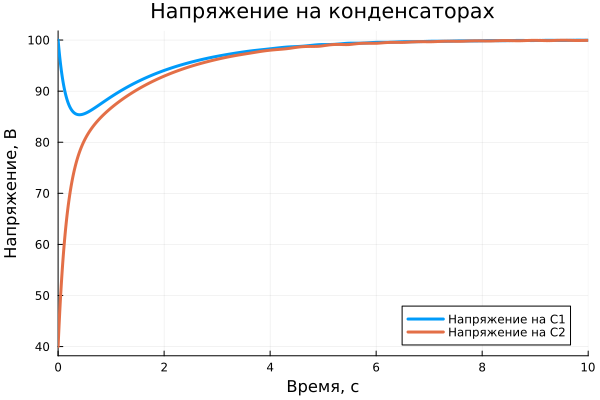

In [4]:
plot(sol, idxs = [capacitor1.v, capacitor2.v],
    labels = ["Напряжение на C1" "Напряжение на C2"],
    xlabel = "Время, с",
    ylabel = "Напряжение, В",
    title = "Напряжение на конденсаторах",
    linewidth = 3)

По графикам видно корректное решение задачи. Начальные напряжения на конденсаторах корректно соответствуют 100 и 40 В. После окончания переходного процесса на обоих конденсаторах устанавливается напряжение 100 В и ток в цепи прекращается.

Будем уменьшать сопротивление R2. При нулевом значении сопротивления задача перейдет в разряд некорректных коммутаций.

In [5]:
R2 = 1e-6
@named resistor2 = Resistor(R = R2)
@named transientModel = ODESystem(rc_eqs, t,
    systems = [resistor1, capacitor1, capacitor2, constant, source, ground, resistor2])
sys = structural_simplify(transientModel)
prob = ODEProblem(sys, Pair[], (0, 10))
sol = solve(prob, Tsit5());

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\sea2525\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:580


При R2 = 1e-6 задача стала жесткой. Библиотека предлагает перейти на решатели жестких задач. Используем Rodas4.

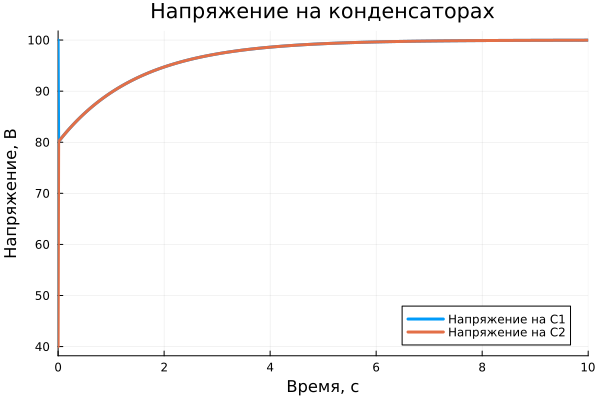

In [6]:
sol = solve(prob, Rodas4());
plot(sol, idxs = [capacitor1.v, capacitor2.v],
    labels = ["Напряжение на C1" "Напряжение на C2"],
    xlabel = "Время, с",
    ylabel = "Напряжение, В",
    title = "Напряжение на конденсаторах",
    linewidth = 3)

Видно практически скачкообразное изменение напряжений на конденсаторах. Попробуем полностью занулить сопротивление.

In [7]:
R2 = 0
@named resistor2 = Resistor(R = R2)
@named transientModel = ODESystem(rc_eqs, t,
    systems = [resistor1, capacitor1, capacitor2, constant, source, ground, resistor2])
sys = structural_simplify(transientModel)
prob = ODEProblem(sys, Pair[], (0, 10))
sol = solve(prob, Rodas4());

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\sea2525\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606


Выдается ошибка. Попробуем изменить топологию схемы, исключив нулевое сопротивление.

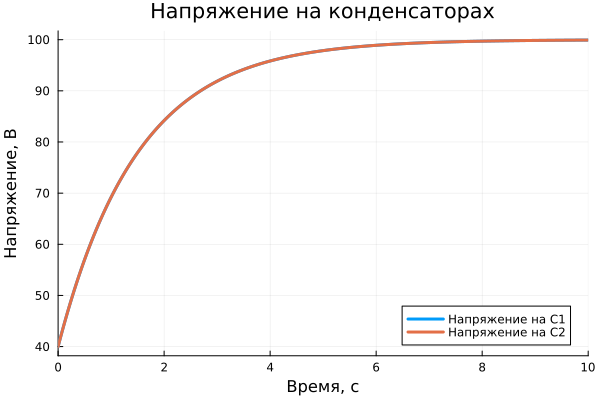

In [8]:
rc_eqs = [connect(constant.output, source.V)
connect(source.p, resistor1.p)
connect(resistor1.n, capacitor1.p, capacitor2.p)
connect(capacitor1.n, source.n, ground.g, capacitor2.n)];
@named transientModel = ODESystem(rc_eqs, t,
    systems = [resistor1, capacitor1, capacitor2, constant, source, ground])
sys = structural_simplify(transientModel)
prob = ODEProblem(sys, Pair[], (0, 10))
sol = solve(prob, Rodas4())

plot(sol, idxs = [capacitor1.v, capacitor2.v],
    labels = ["Напряжение на C1" "Напряжение на C2"],
    xlabel = "Время, с",
    ylabel = "Напряжение, В",
    title = "Напряжение на конденсаторах",
    linewidth = 3)

Теперь сообщения об ошибках нет, но задача решена неверно. Напряжение на конденсаторах согласно обощенному закону коммутации должно быть равным
$$
u_{C}(0+) = \frac{u_{C_1}(0-)\cdot C_1 + u_{C_2}(0-)\cdot C_2}{C_1 + C_2}=\frac{100 + 40\cdot 0.5}{1.5}=80 В
$$
На картинках выше было видно, как при еще учете малого сопротивления значения напряжений почти мгновенно прыгают до 80 В.

## Вывод
Библиотека ModelingToolkit "знает" законы коммутации и законы Кирхгофа для составления системы ДАУ, описывающей схему замещения. Ситуацию с некорректными коммутациями надо разбирать отдельно.